In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import IPython.display as display
from itertools import combinations
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix,\
make_scorer
from xgboost import XGBClassifier
import xgboost as xgb
from IPython.display import display
from sklearn.model_selection import cross_val_score

### 4. 모델 훈련

- Response 변수를 목표변수로 설정 
- XGBoost, CatBoost, LinearRegression 모델 활용
- Grid_Search를 이용하여 여러 파라미터를 기반으로 훈련
- Stepwise Selection을 이용한 최적의 변수선택
- 전체 데이터의 20%에 해당하는 그룹을 Test Group으로 설정
- Test Group의 수익이 극대화되는 모델로 선정
- Precision값과 Recall 값 기록
- 해당 모델이 True로 예측한 그룹과 아닌 그룹의 차이점 시각화

In [2]:
df1 = pd.read_csv('/kaggle/input/arketing-campaign/marketing_campaign.csv', sep = ';')
df1['Age'] = 2014 - df1['Year_Birth']
df2 = df1.drop(columns = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_Revenue', 'Z_CostContact',
                          'Recency', 'Complain', 'Age'])
df2['Marital_Status'] = df2['Marital_Status'].replace({'Divorced' : 'Single', 'Widow' : 'Single',
                                                      'Alone' : 'Single', 'Together' : 'Couple', 
                                                    'Married':'Couple'})
df2['Education'] = df2['Education'].replace({ '2n Cycle' : 'Master'})
df2 = df2[(df2['Marital_Status'] != 'Absurd') & (df2['Marital_Status'] != 'YOLO')]
df2 = df2[df2['Income'] < 180000]

cmp1_df = df2.drop(columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                              'AcceptedCmp2',	'Response'])


In [3]:
cmp1_df['AcceptedCmp1'].value_counts()

AcceptedCmp1
0    2070
1     141
Name: count, dtype: int64

In [4]:
edu_list = ['Basic', 'Graduation', 'Master', 'PhD']
ordinal_encoder = OrdinalEncoder(categories = [edu_list])
label_encoder = LabelEncoder()
cmp1_df['Education'] = ordinal_encoder.fit_transform(cmp1_df[['Education']])
cmp1_df['Marital_Status'] = label_encoder.fit_transform(cmp1_df['Marital_Status'])

X = cmp1_df.drop(columns = ['AcceptedCmp1'])
y = cmp1_df['AcceptedCmp1']


In [5]:
def revenue_score(y_true, y_pred, cost = 1, profit = 20):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    revenue = (tp * profit) - ( (tp+fp) * cost)
    return revenue


revenue_scorer = make_scorer(revenue_score, greater_is_better = True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , 
                                                    random_state =1, stratify =y)


param_grid = {
    'n_estimators' : [100, 150, 200],
    'learning_rate' : [0.05, 0.1],
    'max_depth' : [1],
    'scale_pos_weight' : [20, 25]
}

grid_search = GridSearchCV(
    XGBClassifier(random_state = 1, use_label_encoder = False),
    param_grid,
    cv = 3,
    scoring = revenue_scorer,
    verbose = 1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [1],
                         'n_estimators': [100, 150, 200],
                         'scale_pos_weight': [20, 25]},
             scoring=make_scorer(revenue_score), verbose=1)

In [7]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
test_score = revenue_score(y_test, y_pred)


print("Precision:", precision)
print("Recall:", recall)
print("Test score:", test_score)

Precision: 0.22321428571428573
Recall: 0.8928571428571429
Test score: 388


In [8]:
results = grid_search.cv_results_

results_df = pd.DataFrame({
    'params' : results['params'],
    'mean_test_recall' : results['mean_test_score']
})


sorted_results = results_df.sort_values(by='mean_test_recall', ascending=False)
pd.set_option('display.max_colwidth', None)


In [9]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

true_train = X_train[y_train_pred == 1]
false_train = X_train[y_train_pred == 0]
true_test = X_test[y_test_pred == 1]
false_test = X_test[y_test_pred == 0]

true_df = pd.concat( (true_train, true_test), axis = 0 )
false_df = pd.concat( (false_train, false_test), axis = 0 )


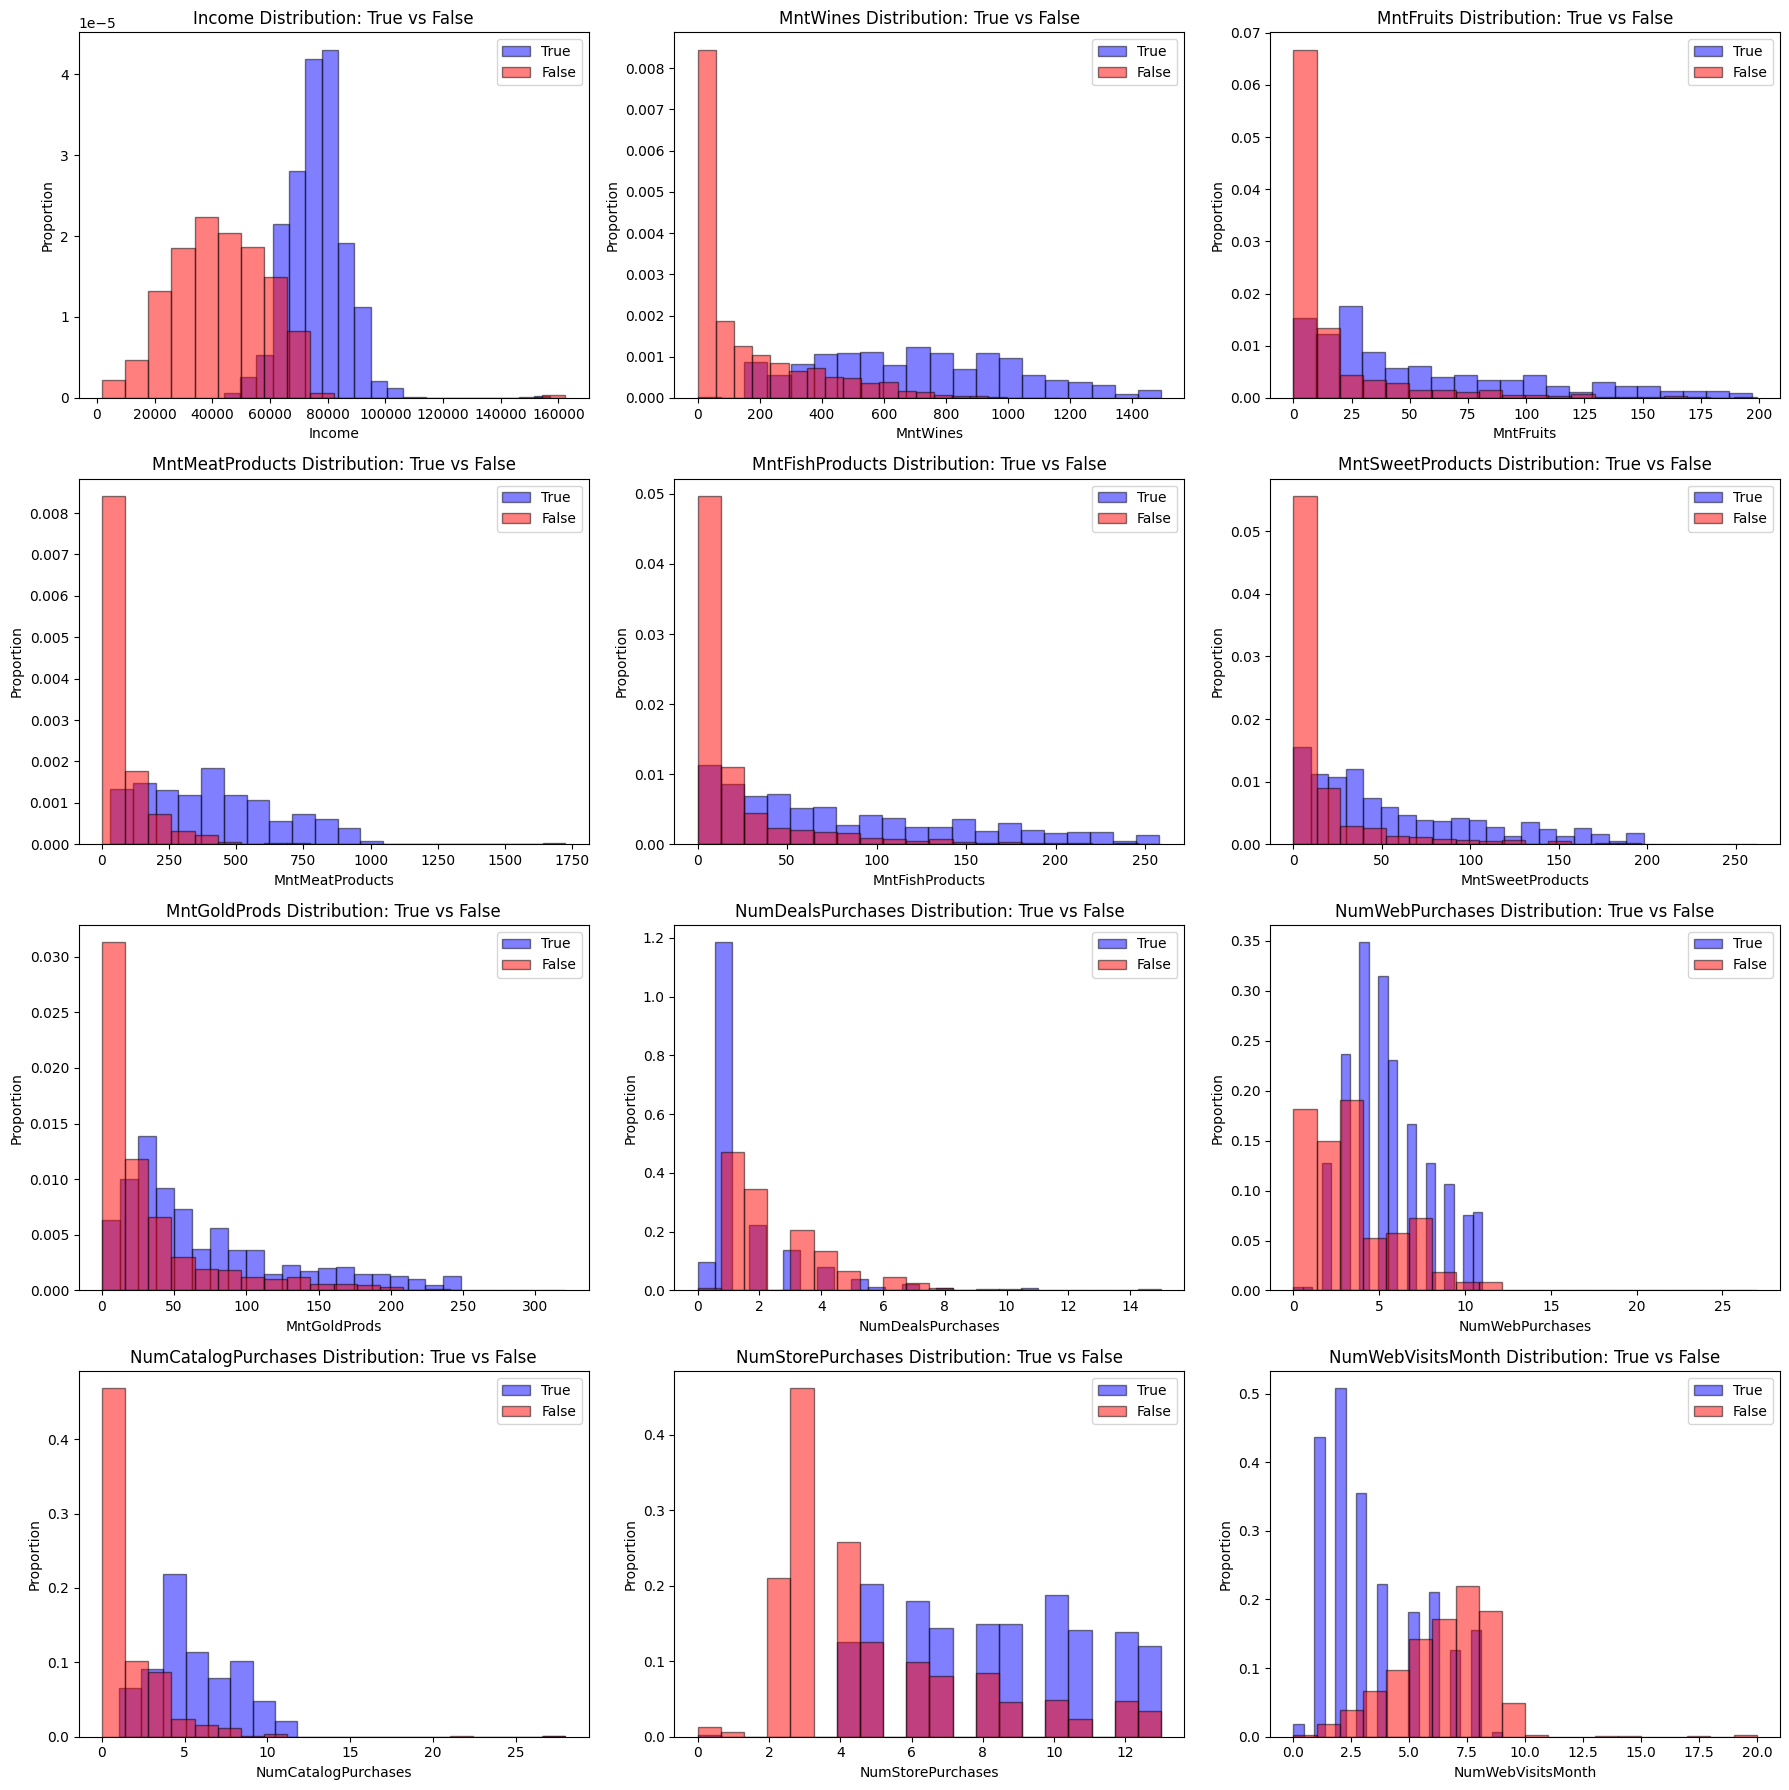

In [10]:
continuous_list =['Income', 'MntWines', 'MntFruits', 'MntMeatProducts',	'MntFishProducts',
                  'MntSweetProducts',	'MntGoldProds',	'NumDealsPurchases', 
                  'NumWebPurchases',	'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth']


def compare_hist(df1, df2):
    
    fig, axes = plt.subplots(4, 3, figsize = (18, 18))
    axes = axes.flatten()

    for i, col in enumerate(continuous_list):
        axes[i].hist(df1[col], bins = 20, alpha = 0.5, label = 'True', color = 'blue',
                     edgecolor = 'black', density = True)
        axes[i].hist(df2[col], bins = 20, alpha = 0.5, label = 'False', color = 'red',
                     edgecolor ='black', density = True)
        
        axes[i].set_title(f'{col} Distribution: True vs False')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Proportion')
        axes[i].legend()
        
    plt.tight_layout()
    plt.show()


compare_hist(true_df, false_df)

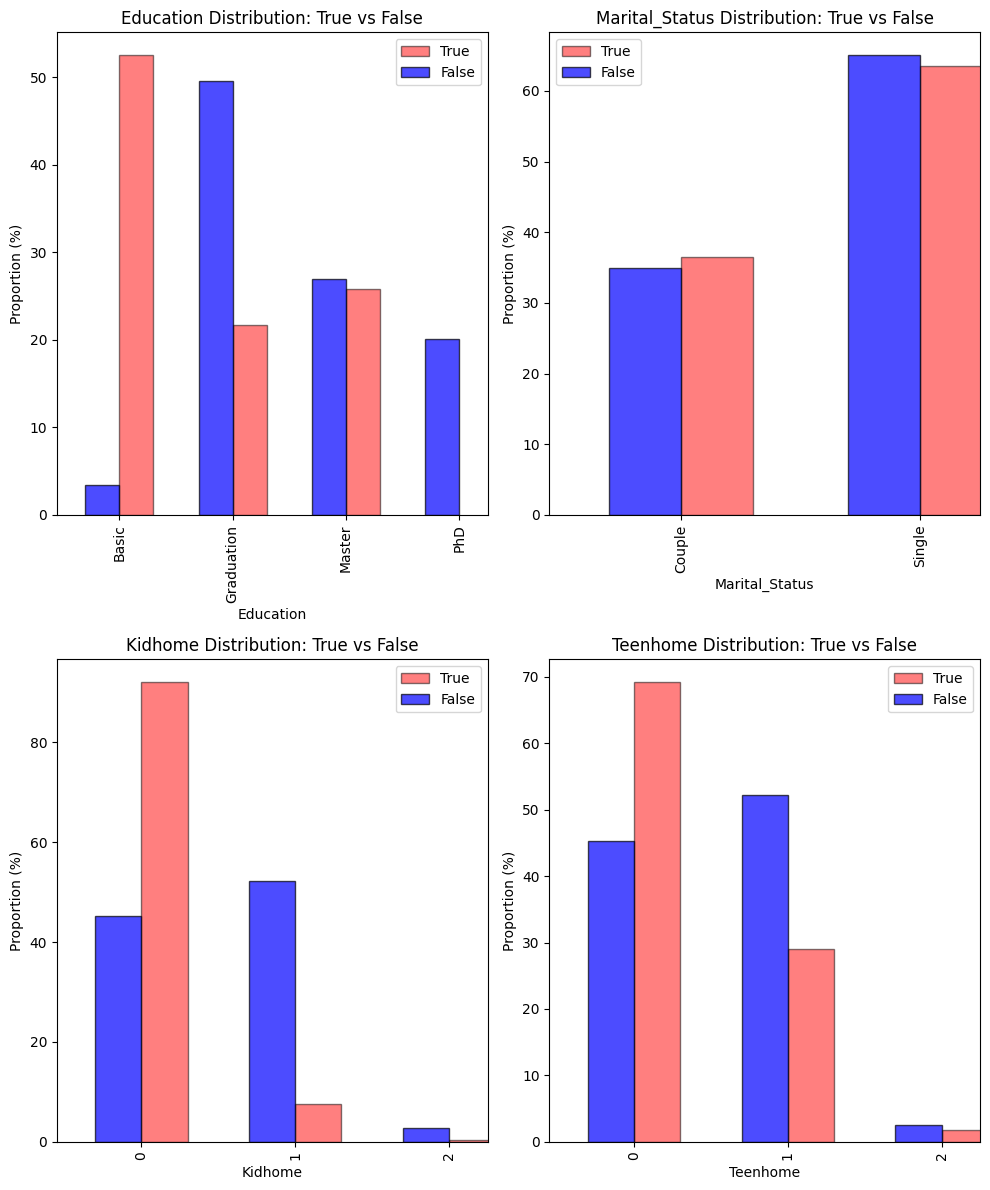

In [11]:
education_dict = {0 : 'Basic', 1 : 'Graduation', 2 : 'Master', 3 : 'PhD'}
marital_dict = {0 : 'Single', 1 : 'Couple'}
true_df['Education'] = true_df['Education'].replace(education_dict)
true_df['Marital_Status'] = true_df['Marital_Status'].replace(marital_dict)
false_df['Education'] = false_df['Education'].replace(education_dict)
false_df['Marital_Status'] = false_df['Marital_Status'].replace(marital_dict)
category_list = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome']

def compare_category(df1, df2):
    fig, axes = plt.subplots(2, 2, figsize=(10, 12))  
    axes = axes.flatten() 

    for i, col in enumerate(category_list):

        true_counts = df1[col].value_counts(normalize = True) * 100
        false_counts = df2[col].value_counts(normalize = True) * 100

        ax = axes[i]
        width = 0.3
        true_counts.sort_index().plot(kind = 'bar', width = width, position = 0, alpha = 0.5,
                                     label = 'True', color  = 'red', edgecolor = 'black', ax = ax)
        false_counts.sort_index().plot(kind='bar', width=width, position=1, alpha = 0.7,
                                       label='False', color='blue', edgecolor='black', ax=ax)
        
        ax.set_title(f'{col} Distribution: True vs False')
        ax.set_xlabel(col)
        ax.set_ylabel('Proportion (%)')
        ax.legend()

    plt.tight_layout()
    plt.show()

compare_category(true_df, false_df)

<Figure size 1000x800 with 0 Axes>

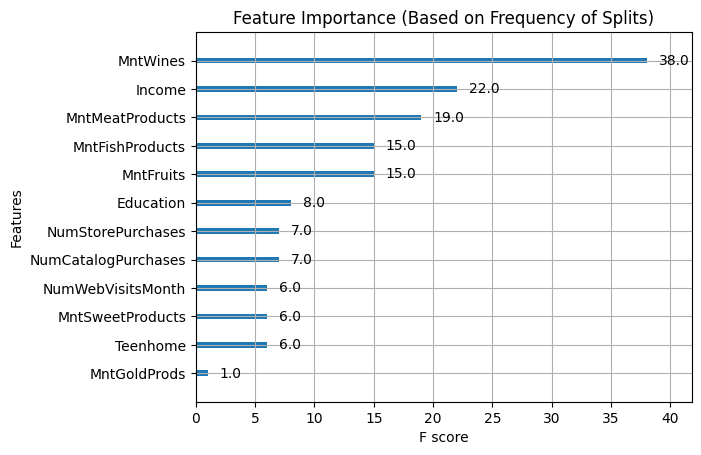

In [12]:
best_model = grid_search.best_estimator_

plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='weight', show_values=True)
plt.title("Feature Importance (Based on Frequency of Splits)")
plt.show()


In [13]:
df2['AcceptedCmp2'].value_counts()

AcceptedCmp2
0    2181
1      30
Name: count, dtype: int64

In [14]:
params = param_grid.keys()
for param in params:
    value = best_model.get_params()[param]
    print(f'{param} : {value}')

n_estimators : 150
learning_rate : 0.1
max_depth : 1
scale_pos_weight : 25


In [15]:
from mlxtend.feature_selection import SequentialFeatureSelector

xgb_model = XGBClassifier(random_state = 1, n_estimators = 150, learning_rate = 0.1, max_depth = 1,
                         scale_pos_weight = 25, use_label_encoder = False)


revenue_scorer = make_scorer(revenue_score, greater_is_better = True)



sfs = SequentialFeatureSelector(
    estimator=xgb_model,
    k_features= (7, 12),
    forward=True,
    floating=True,  
    scoring=revenue_scorer,
    cv=3
)

sfs.fit(X, y)

print("Selected features:", sfs.k_feature_names_)



Selected features: ('Education', 'Marital_Status', 'Income', 'Teenhome', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'NumStorePurchases', 'NumWebVisitsMonth')


In [16]:
selected_features = list(sfs.k_feature_names_)
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=1)

xgb_model = XGBClassifier(
    random_state = 1,
    scale_pos_weight = 25,
    n_estimators = 150,
    max_depth = 1,
    learning_rate = 0.1,
    use_label_encoder = False
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cross_val_revenue = cross_val_score(xgb_model, X_selected, y, cv=3, scoring=revenue_scorer)


print("Precision:", precision)
print("Recall:", recall)
print("Cross-validation score:", cross_val_revenue.mean())


Precision: 0.22123893805309736
Recall: 0.8928571428571429
Cross-validation score: 655.3333333333334


In [17]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C' : [0.01, 0.1, 1, 10],
    'class_weight' : [None, 'balanced'],
    'solver' : ['liblinear', 'lbfgs']
}

grid_search_lr = GridSearchCV(
    LogisticRegression(random_state = 1, max_iter = 500),
    param_grid_lr,
    cv = 3,
    scoring = revenue_scorer,
    verbose = 1
)

grid_search_lr.fit(X_train, y_train)
best_lr_model = grid_search_lr.best_estimator_

best_lr_model.fit(X_train, y_train)
y_pred = best_lr_model.predict(X_test)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

cross_val_revenue = cross_val_score(best_lr_model, X_train, y_train, cv = 3, scoring = revenue_scorer)

print('Recall:', recall)
print('Precision:', precision)
print('Cross_val_revenue:', cross_val_revenue.mean())

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Recall: 0.8928571428571429
Precision: 0.24509803921568626
Cross_val_revenue: 483.0


In [18]:
from catboost import CatBoostClassifier


param_grid_cb = {
    'iterations': [100, 200],  # 트리의 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'depth': [1, 3, 5, 7],  # 트리의 깊이
    'class_weights': [[1, 2], [1, 3]]  # 클래스 불균형 처리
}

# CatBoost 모델에 GridSearchCV 적용
grid_search_cb = GridSearchCV(
    CatBoostClassifier(random_state=1, verbose=0),  # verbose=0으로 출력 억제
    param_grid_cb,
    cv=3,
    scoring=revenue_scorer,
    verbose=1
)


grid_search_cb.fit(X_train, y_train)
best_cb_model = grid_search_cb.best_estimator_

best_cb_model.fit(X_train, y_train)
y_pred = best_cb_model.predict(X_test)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

cross_val_revenue = cross_val_score(best_lr_model, X_train, y_train, cv = 3, scoring = revenue_scorer)

print('Recall:', recall)
print('Precision:', precision)
print('Cross_val_revenue:', cross_val_revenue.mean())

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Recall: 0.42857142857142855
Precision: 0.41379310344827586
Cross_val_revenue: 483.0


In [35]:
df1 = pd.read_csv('/kaggle/input/arketing-campaign/marketing_campaign.csv', sep = ';')
df1['Age'] = 2014 - df1['Year_Birth']
df2 = df1.drop(columns = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_Revenue', 'Z_CostContact',
                          'Recency', 'Complain', 'Age'])
df2['Marital_Status'] = df2['Marital_Status'].replace({'Divorced' : 'Single', 'Widow' : 'Single',
                                                      'Alone' : 'Single', 'Together' : 'Couple', 
                                                    'Married':'Couple'})
df2['Education'] = df2['Education'].replace({ '2n Cycle' : 'Master'})
df2 = df2[(df2['Marital_Status'] != 'Absurd') & (df2['Marital_Status'] != 'YOLO')]
df2 = df2[df2['Income'] < 180000]

cmp1_df = df2.drop(columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                              'AcceptedCmp2',	'Response'])

edu_list = ['Basic', 'Graduation', 'Master', 'PhD']
ordinal_encoder = OrdinalEncoder(categories = [edu_list])
label_encoder = LabelEncoder()
df2['Education'] = ordinal_encoder.fit_transform(df2[['Education']])
df2['Marital_Status'] = label_encoder.fit_transform(df2['Marital_Status'])

X = df2.drop(columns = ['Response'])
y = df2['Response']


In [50]:
revenue_scorer = make_scorer(revenue_score, greater_is_better = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , 
                                                    random_state =1, stratify =y)

def revenue_score(y_true, y_pred, cost = 2, profit = 20):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    revenue = (tp * profit) - ( (tp+fp) * cost)
    return revenue

revenue_scorer = make_scorer(revenue_score, greater_is_better = True)

param_grid = {
    'n_estimators' : [100, 150],
    'learning_rate' : [0.05, 0.1],
    'max_depth' : [1, 2],
    'scale_pos_weight' : [20, 25]
}

grid_search = GridSearchCV(
    XGBClassifier(random_state = 1, use_label_encoder = False),
    param_grid,
    cv = 3,
    scoring = revenue_scorer,
    verbose = 1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
crossval_scores = cross_val_score(best_model, X_test, y_test, cv = 3, scoring = revenue_scorer )


print("Precision:", precision)
print("Recall:", recall)
print("Test score:", test_score.mean())





Fitting 3 folds for each of 16 candidates, totalling 48 fits
Precision: 0.24180327868852458
Recall: 0.8939393939393939
Test score: 388.0


In [51]:


sfs = SequentialFeatureSelector(
    estimator=best_model,
    k_features= (14, 16),
    forward=True,
    floating=True,  
    scoring=revenue_scorer,
    cv=3
)

sfs.fit(X, y)

print("Selected features:", sfs.k_feature_names_)
print( len(sfs.k_feature_names_))


Selected features: ('Education', 'Marital_Status', 'Income', 'Teenhome', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2')
15


In [52]:

selected_features = list(sfs.k_feature_names_)
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=1)



best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cross_val_revenue = cross_val_score(xgb_model, X_test, y_test, cv=3, scoring=revenue_scorer)


print("Precision:", precision.round(4))
print("Recall:", recall.round(4))
print("Cross-validation score:", cross_val_revenue.mean().round(4))

Precision: 0.2381
Recall: 0.9091
Cross-validation score: 171.3333


In [53]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

true_train = X_train[y_train_pred == 1]
false_train = X_train[y_train_pred == 0]
true_test = X_test[y_test_pred == 1]
false_test = X_test[y_test_pred == 0]

true_df = pd.concat( (true_train, true_test), axis = 0 )
false_df = pd.concat( (false_train, false_test), axis = 0 )


In [54]:
print("True Train:", true_train.shape)
print("False Train:", false_train.shape)
print("True Test:", true_test.shape)
print("False Test:", false_test.shape)


True Train: (959, 15)
False Train: (809, 15)
True Test: (252, 15)
False Test: (191, 15)


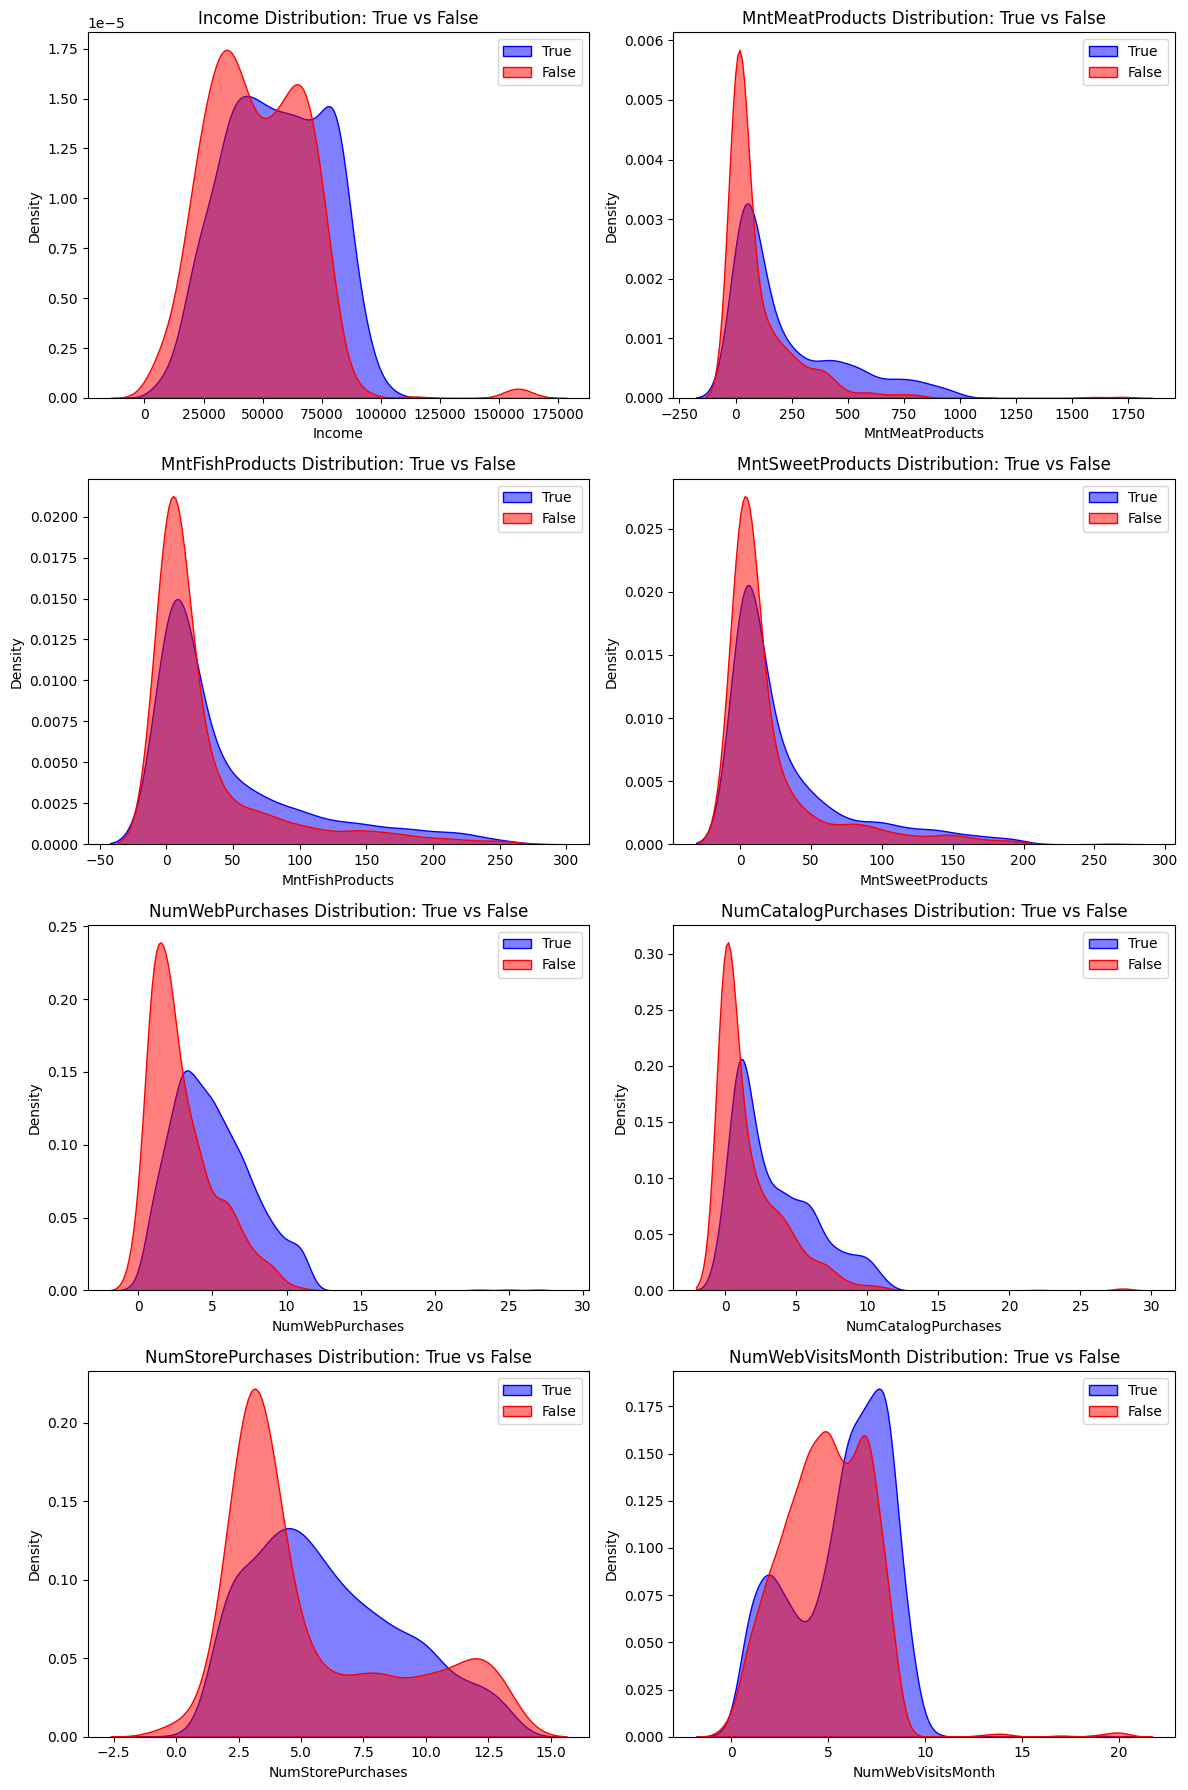

In [55]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

continuous_list =[ 'Income',  'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
                  'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

def compare_kde(df1, df2):
    fig, axes = plt.subplots(4, 2, figsize=(12, 18))
    axes = axes.flatten()

    for i, col in enumerate(continuous_list):
        sns.kdeplot(df1[col], ax=axes[i], label='True', color='blue', fill=True, alpha=0.5)
        sns.kdeplot(df2[col], ax=axes[i], label='False', color='red', fill=True, alpha=0.5)
        
        axes[i].set_title(f'{col} Distribution: True vs False')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
        axes[i].legend()

    plt.tight_layout()
    plt.show()


compare_kde(true_df, false_df)

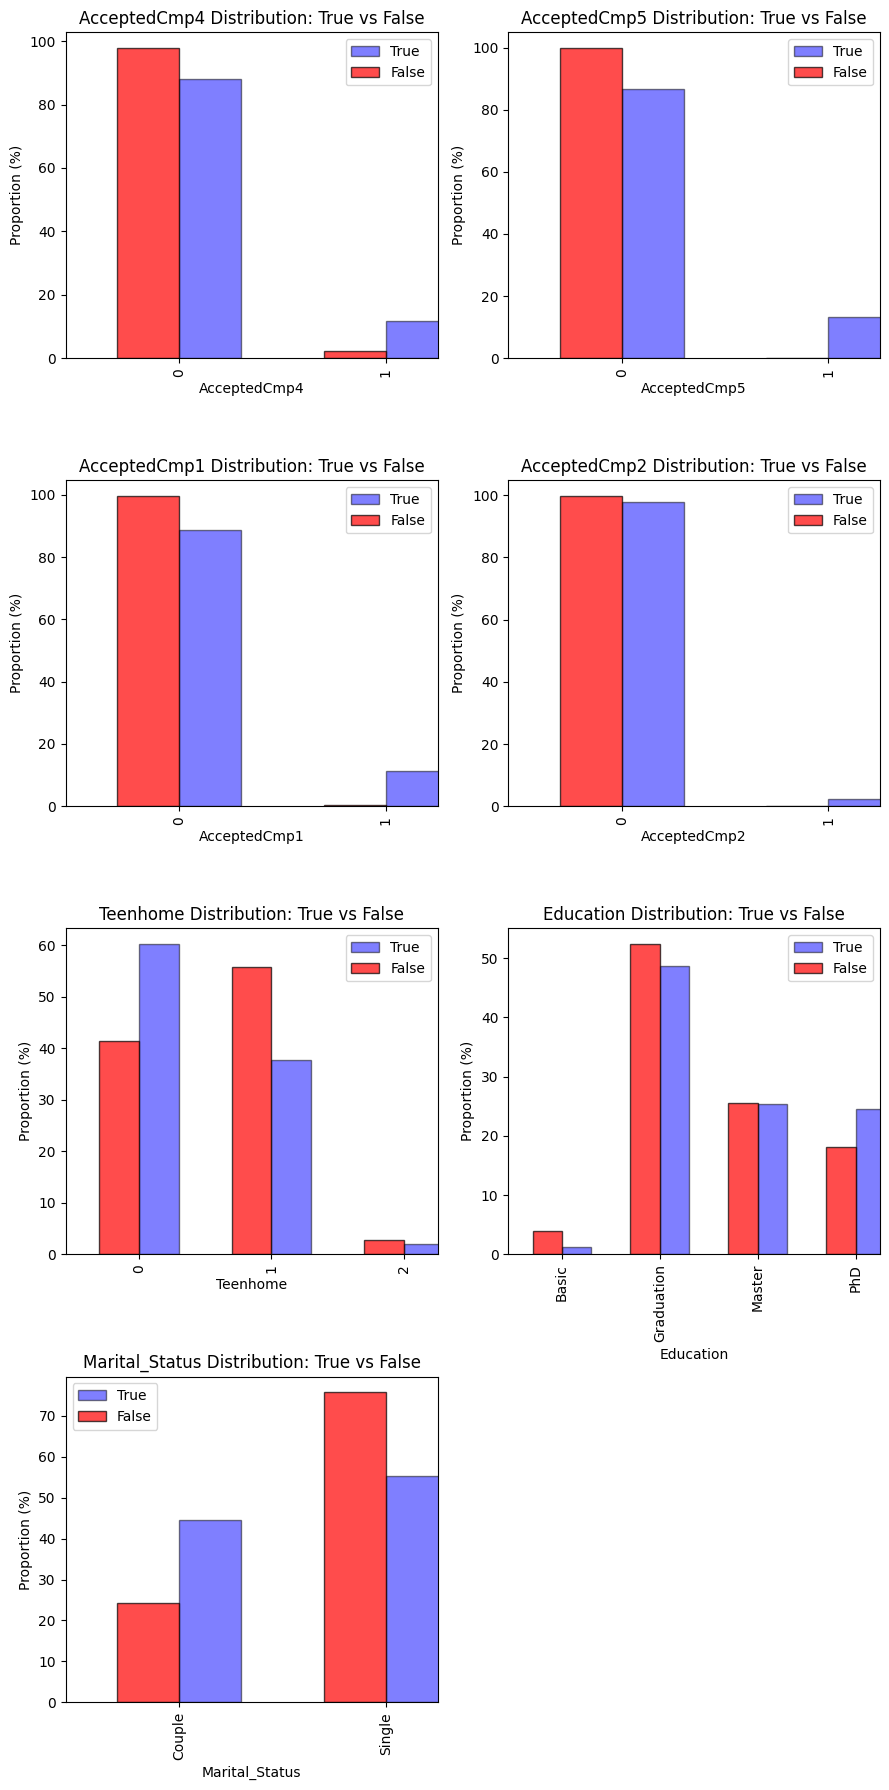

In [25]:
education_dict = {0 : 'Basic', 1 : 'Graduation', 2 : 'Master', 3 : 'PhD'}
marital_dict = {0 : 'Single', 1 : 'Couple'}
true_df['Education'] = true_df['Education'].replace(education_dict)
true_df['Marital_Status'] = true_df['Marital_Status'].replace(marital_dict)
false_df['Education'] = false_df['Education'].replace(education_dict)
false_df['Marital_Status'] = false_df['Marital_Status'].replace(marital_dict)

category_list = ['AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
                 'Teenhome', 'Education', 'Marital_Status']

def compare_category(df1, df2):
    fig, axes = plt.subplots(4, 2, figsize=(9, 18))  
    axes = axes.flatten() 

    for i, col in enumerate(category_list):

        true_counts = df1[col].value_counts(normalize = True) * 100
        false_counts = df2[col].value_counts(normalize = True) * 100

        ax = axes[i]
        width = 0.3
        true_counts.sort_index().plot(kind = 'bar', width = width, position = 0, alpha = 0.5,
                                     label = 'True', color  = 'blue', edgecolor = 'black', ax = ax)
        false_counts.sort_index().plot(kind='bar', width=width, position=1, alpha = 0.7,
                                       label='False', color='red', edgecolor='black', ax=ax)
        
        ax.set_title(f'{col} Distribution: True vs False')
        ax.set_xlabel(col)
        ax.set_ylabel('Proportion (%)')
        ax.legend()

    if len(category_list) < len(axes):
        fig.delaxes(axes[-1])
        
    plt.tight_layout()
    plt.show()

compare_category(true_df, false_df)

<Figure size 1000x800 with 0 Axes>

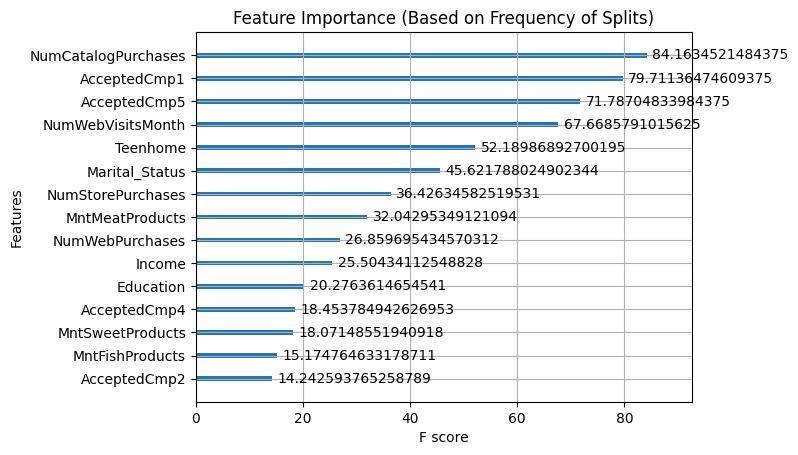

In [27]:

plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='gain', show_values=True)
plt.title("Feature Importance (Based on Frequency of Splits)")
plt.show()

#### 모델 훈련 결과

- XGB 모델이 가장 뛰어난 성능을 보임
- Precision 값 0.23 Recall 값 0.90로 모델은 프로모션 수용 가능성이 있는 고객들에게 캠페인을 진행하고자 함
- 주 타겟 고객층은 Response를 목표변수로 했을 땐 각 변수의 차이가 상대적으로 적은 편
- Response의 경우 기대수익은 400명을 대상으로 171달러
- Response의 타겟 고객층의 특징
1. 고기소비량 500파운드 이상 2. Income은 8만달러 이상 3. 웹페이지 구매경험 많음 4. 카탈로그 구입 경험 비교적 많음 5. 다른 캠페인을 수용하는 경향성

## 최종 요약


### 목적

본 데이터분석의 목적은 <br><br>
1. 수익을 극대화할 수 있는 모델을 제작하고 <br>
2. 타겟 고객층의 인적정보를 분석하는 것 <br>
에 있습니다

### 과정

- 신뢰성이 낮은 데이터는 제거하였습니다
- Income이 공백인 경우 XGB 모델을 활용하여 Impute하였습니다 
- XGB, CatBoost, LinearRegression 모델 중 가장 우수한 성능을 보인 XGB 모델을 선택하였습니다
- Campaign1과 Response 변수를 각각 목표 변수로 잡고 모델을 학습시켰습니다
- 각 경우의 주 타겟 고객층을 분석하였습니다
- 비용, 수익값을 바꾸어 보며 여러 경우를 가정하며 학습시켰습니다

### 결과

1. 비용과 수익값에 관계 없이, Precision값은 0.20 ~ 0.24, Recall 값은 0.88 ~ 0.90를 유지하였습니다. 이는 적자가 나는 경우에도 마찬가지였습니다
2. Response가 목표변수일 경우 주 타겟 고객층은 논타겟 그룹에 비해 고기소비량, 수입, 웹페이지 구매경험, 카탈로그 구입경험에서 상대적으로 많은 경향을 보였습니다. 또한 다른 캠페인을 수용하는 경향성도 보였습니다

### 인사이트 도출

- 모델들의 학습결과는 프로모션을 수용할 가능성이 높은 고객층을 노리기보단, 낮은 가능성을 지닌 잠재적 고객들을 대상으로도 캠페인을 진행할 것을 시사합니다
- 또한, 1. 고기소비량이 500파운드 이상 2. 수입이 8만달러 이상 3. 웹페이지 구매경험이 상대적으로 많음 4. 카탈로그 구입 경험이 상대적으로 많음 5. 다른 캠페인들을 수용한 경험이 있음
- 위의 조건들을 만족하는 고객을 타겟으로 해야함을 보여줍니다

### 한계

- 위에서 설명한 변수들 외에, 자녀의 수나 결혼 상태, 상점에서의 구매 경험 등 역시 중요한 변수로서 작용하였으나 해당 변수들이 구체적으로 어떻게 영향을 미쳤는지는 설명력이 부족합니다
- 변수들간의 상호작용으로 어떻게 모델학습에 영향을 미쳤는지 추가적인 분석이 필요합니다